<font size ="8"> <div align="center">**Predictive Analytics: New York City Bus Ride Duration Prediction**</div></font>
<font size ="5"> <div align="center">By **Jon Nyner Gavan**</div></font>


--------------------
# **Context of the Project (New York City Bus)**
--------------------

<p align = "justify">
In this project, the data on New York City Bus network is comprehensively explored and looked into. Moreover, the machine learning concepts learned thus far, is applied to this particular
dataset and used to train a predictive model than can accurately predict the duration for a particular bus ride.

-----------------
## **Dataset Description**
-----------------

The ``trips`` table has the following fields
* ``id`` which uniquely identifies the trip
* ``Transport_Service`` is the transport company - in our case study we have data from 4 different transport companies
* ``pickup_datetime`` the time stamp for pickup
* ``dropoff_datetime`` the time stamp for drop-off
* ``passenger_count`` the number of passengers for the trip
* ``trip_distance`` total distance of the trip in miles
* ``pickup_longitude`` the longitude for pickup
* ``pickup_latitude`` the latitude for pickup
* ``dropoff_longitude``the longitude of dropoff
* ``dropoff_latitude`` the latitude of dropoff
* ``payment_type`` a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= Unknown
* ``trip_duration`` this is the duration we would like to predict using other fields
* ``pickup_neighborhood`` a one or two letter id of the neighborhod where the trip started
* ``dropoff_neighborhood`` a one or two letter id of the neighborhod where the trip ended

-----------------
## **Objective of the Study**
-----------------

- To Build a predictive model, for predicting the duration for the bus ride.
- Use Automated feature engineering to create new features



### **Importing the necessary libraries and overview of the dataset**

**Importing the necessary libraries**

In [ ]:
# Installing featuretools library

!pip install featuretools==0.27.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.3/327.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# Featauretools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings("ignore")

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


**Pre-defining some useful functions for Data Manipulation**

In [ ]:
# Defining some useful functions

# To preview first five rows.
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]

# To see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

# To generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)

def column_string(n):
    string = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string

# To compute features using automated feature engineering.
def compute_features(features, cutoff_time):
    # Shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

**Loading the datasets**

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Importing the datasets
trips = pd.read_csv('BUS_SERVICE.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
trips["payment_type"] = trips["payment_type"].apply(str)
trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')


**Viewing the Dataset**

In [ ]:
# Taking a quick look at the first 10 rows of data having the fewest number of nulls
preview(trips, 10)

,id,Transport_service,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,3,2019-01-01 00:00:00,2019-01-01 00:06:00,1,1.32,-73.961258,40.796200,-73.950050,40.787312,3,387,AH,C
997,997,4,2019-01-01 02:38:00,2019-01-01 02:52:00,3,5.57,-73.952347,40.824081,-73.996429,40.759918,1,828,AL,P
996,996,4,2019-01-01 02:38:00,2019-01-01 02:41:00,2,0.20,-73.980171,40.745308,-73.984192,40.745892,2,184,Y,AO
995,995,3,2019-01-01 02:38:00,2019-01-01 02:52:00,1,2.83,-73.991966,40.759331,-74.004707,40.724442,2,815,P,AB
994,994,2,2019-01-01 02:38:00,2019-01-01 02:49:00,2,2.48,-73.961441,40.694302,-73.959938,40.662540,1,655,V,AF
993,993,3,2019-01-01 02:38:00,2019-01-01 02:40:00,4,0.72,-73.974014,40.782967,-73.969894,40.788155,2,162,I,U
992,992,2,2019-01-01 02:38:00,2019-01-01 03:13:00,3,10.50,-73.956985,40.766346,-73.966179,40.674366,3,2131,K,V
991,991,4,2019-01-01 02:38:00,2019-01-01 02:52:00,3,6.80,-73.911682,40.775295,-73.903908,40.817696,2,898,W,S
990,990,1,2019-01-01 02:38:00,2019-01-01 03:22:00,1,13.80,-73.976143,40.775990,-73.940956,40.676426,2,2693,AV,AW
989,989,2,2019-01-01 02:38:00,2019-01-01 03:08:00,1,9.00,-73.981331,40.780663,-73.848824,40.722755,3,1841,AV,B


In [ ]:
# Drop the rows where at least one element is missing.
trips=trips.dropna()

For the features used in the model the "**dropoff_datetime**" needs to be removed as this value would not be known for real-time prediction and you can basically take the difference between the pickup and dropoff time to find the duration.So, this will restrict our model to be **robust** and **reliable**. So, dropping this feature will help us to avoid **data leakage**.

Data leakage in machine learning occurs when the data used to train a machine learning algorithm contains information that the model is attempting to predict, resulting in unreliable and poor prediction outcomes after model deployment.

In [ ]:
# Dropping the dropoff_datetime column
trips. drop("dropoff_datetime", axis=1, inplace=True)

In [ ]:
# Check the first five rows of the data
trips.head()

,id,Transport_service,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,3,2019-01-01 00:00:00,1,1.32,-73.961258,40.796200,-73.950050,40.787312,3,387,AH,C
1,1,1,2019-01-01 00:01:00,3,13.70,-73.956169,40.707756,-73.939949,40.839558,3,1568,Z,S
2,2,4,2019-01-01 00:01:00,1,5.30,-73.993103,40.752632,-73.953903,40.816540,1,1219,D,AL
3,3,2,2019-01-01 00:01:00,2,7.19,-73.983009,40.731419,-73.930969,40.808460,2,873,AT,J
4,4,1,2019-01-01 00:02:00,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1091,AG,AV


### **Exploratory Data Analysis**

**Data types and number of unique values**

In [ ]:
# Checking the info of the dataset
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1499
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1452 non-null   int64         
 1   Transport_service     1452 non-null   int64         
 2   pickup_datetime       1452 non-null   datetime64[ns]
 3   passenger_count       1452 non-null   int64         
 4   trip_distance         1452 non-null   float64       
 5   pickup_longitude      1452 non-null   float64       
 6   pickup_latitude       1452 non-null   float64       
 7   dropoff_longitude     1452 non-null   float64       
 8   dropoff_latitude      1452 non-null   float64       
 9   payment_type          1452 non-null   object        
 10  trip_duration         1452 non-null   int64         
 11  pickup_neighborhood   1452 non-null   object        
 12  dropoff_neighborhood  1452 non-null   object        
dtypes: datetime64[ns](

- There are 1452 non null values in the dataset.

In [ ]:
# Check the uniques values in each columns
trips.nunique()

id                      1452
Transport_service          4
pickup_datetime          259
passenger_count            4
trip_distance            531
pickup_longitude        1338
pickup_latitude         1418
dropoff_longitude       1331
dropoff_latitude        1416
payment_type               3
trip_duration            969
pickup_neighborhood       47
dropoff_neighborhood      49
dtype: int64

- Transport_service has only 4 unique values, implies there are only 4 transport service companies.
- Passenger count has 4 unique values and payment type have 3.
- The dataset contains 49 distinct dropoff neighbourhoods and 47 distinct pickup neighbourhoods.

**Checking summary statistics of the dataset**

In [ ]:
# Checking the descriptive stats of the data
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1452.0,749.218320,434.555493,0.000000,369.750000,749.500000,1125.250000,1499.000000
Transport_service,1452.0,2.488292,1.123890,1.000000,1.000000,2.000000,4.000000,4.000000
passenger_count,1452.0,2.506198,1.111603,1.000000,2.000000,2.000000,4.000000,4.000000
trip_distance,1452.0,3.173320,2.798477,0.000000,1.300000,2.250000,4.260000,17.990000
pickup_longitude,1452.0,-73.973295,0.025778,-74.017311,-73.989311,-73.979614,-73.961092,-73.781807
pickup_latitude,1452.0,40.750311,0.029513,40.638889,40.733079,40.751900,40.768478,40.847500
dropoff_longitude,1452.0,-73.965157,0.034889,-74.024834,-73.988117,-73.974369,-73.950407,-73.770943
dropoff_latitude,1452.0,40.750691,0.038322,40.633560,40.729924,40.751728,40.774967,40.848629
trip_duration,1452.0,828.261019,528.279643,18.000000,428.000000,708.000000,1116.500000,3201.000000


- The median and 75th percentile of the passenger count is 2 and  4 respectively.
- Average trip distance is 3.17km, with a maximum value of 18km and Minimum for trip distance is 0.
- Average trip duration is 828 sec.

**Checking for the rows for which trip_distance is 0**

In [ ]:
# Chekcing the rows where trip distance is 0
trips[trips['trip_distance']==0]

,id,Transport_service,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
880,880,2,2019-01-01 02:15:00,4,0.0,-74.002586,40.750298,-74.002861,40.750446,2,36,AG,AG
1116,1116,1,2019-01-01 03:01:00,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,151,H,H
1455,1455,1,2019-01-01 04:09:00,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,80,AR,AR
1488,1488,2,2019-01-01 04:16:00,3,0.0,-74.014198,40.709988,-74.014198,40.709988,2,18,AU,AU


- We can observe that, where trip distance is 0 trip duration is not 0, hence we can replace those values.
- There are 4 such rows

**Trip distance missing value imputation with column median**

In [ ]:
# Imputing the trip distance column with its meadian value
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())
trips[trips['trip_distance']==0].count()

id                      0
Transport_service       0
pickup_datetime         0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

In [ ]:
# Checking rows with 0 trip duration
trips[trips['trip_duration']==0]

,id,Transport_service,pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood


- There are no such rows with trip_duration=0

#### **Univariate Analysis**

**Checking Distributions of numerical columns**

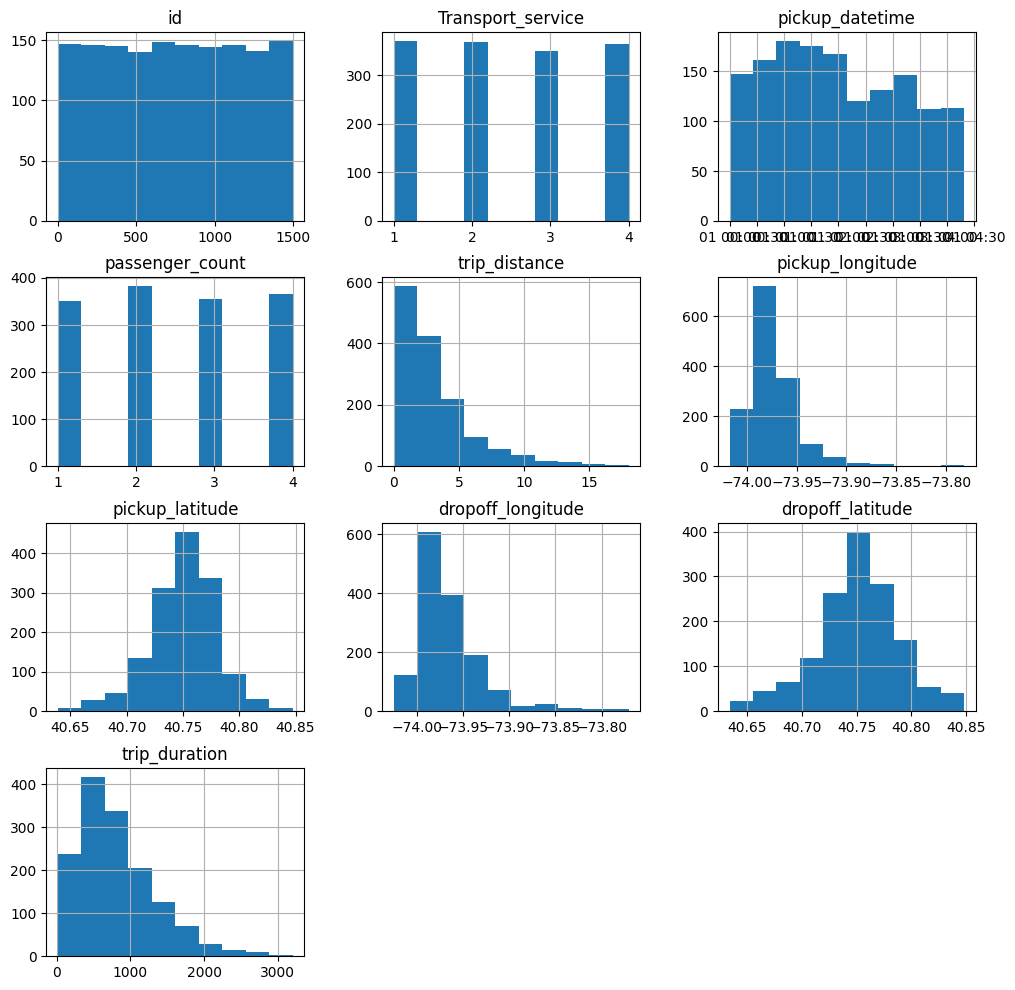

In [ ]:
# Plotting the histograms of numerical columns
trips.hist(figsize=(12,12))
plt.show()

- Pickup latitude,  dropoff latitude are nearly normal distribution, while  pickup longitude,dropoff longitude  are a bit right skewed.
- Trip distance seem to have some outlier, which we can investigate through boxplot.
- trip duration is also rightly skewed.

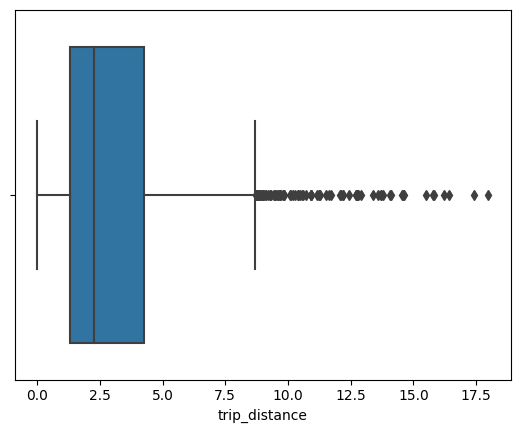

In [ ]:
# Looking at outliers in the trip_distance column using a boxplot
sns.boxplot(x = trips['trip_distance'])
plt.show()

- We can see there is an extreme outlier in the dataset.

**Checking Distributions of Categorical columns**

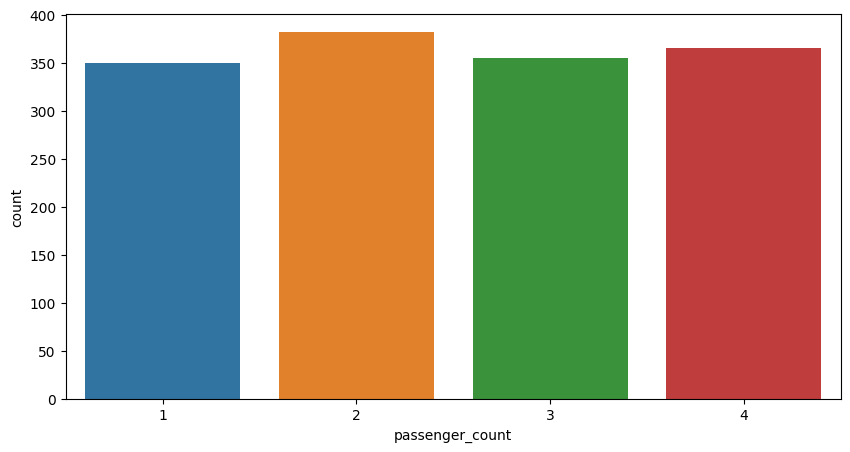

In [ ]:
# Looking at distribution of passenger_count
plt.figure(figsize=(10,5))
sns.countplot(x = trips.passenger_count)
plt.show()

In [ ]:
# Looking at the percentage values of each passenger_count
trips.passenger_count.value_counts(normalize=True)

2    0.263085
4    0.251377
3    0.244490
1    0.241047
Name: passenger_count, dtype: float64

- The distribution of the passenger count is nearly same.

<Axes: >

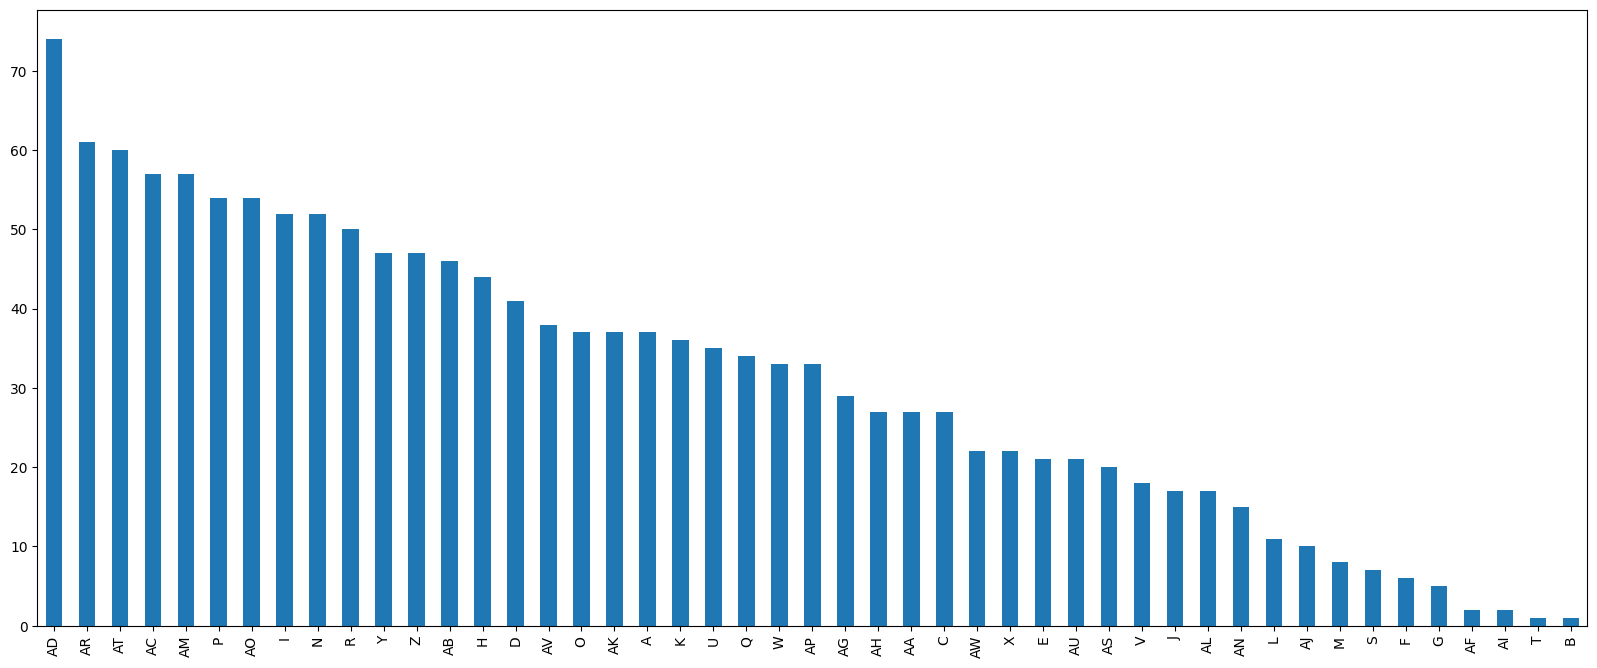

In [ ]:
# Looking at distribution of pickup_neighborhood
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,8))

<Axes: >

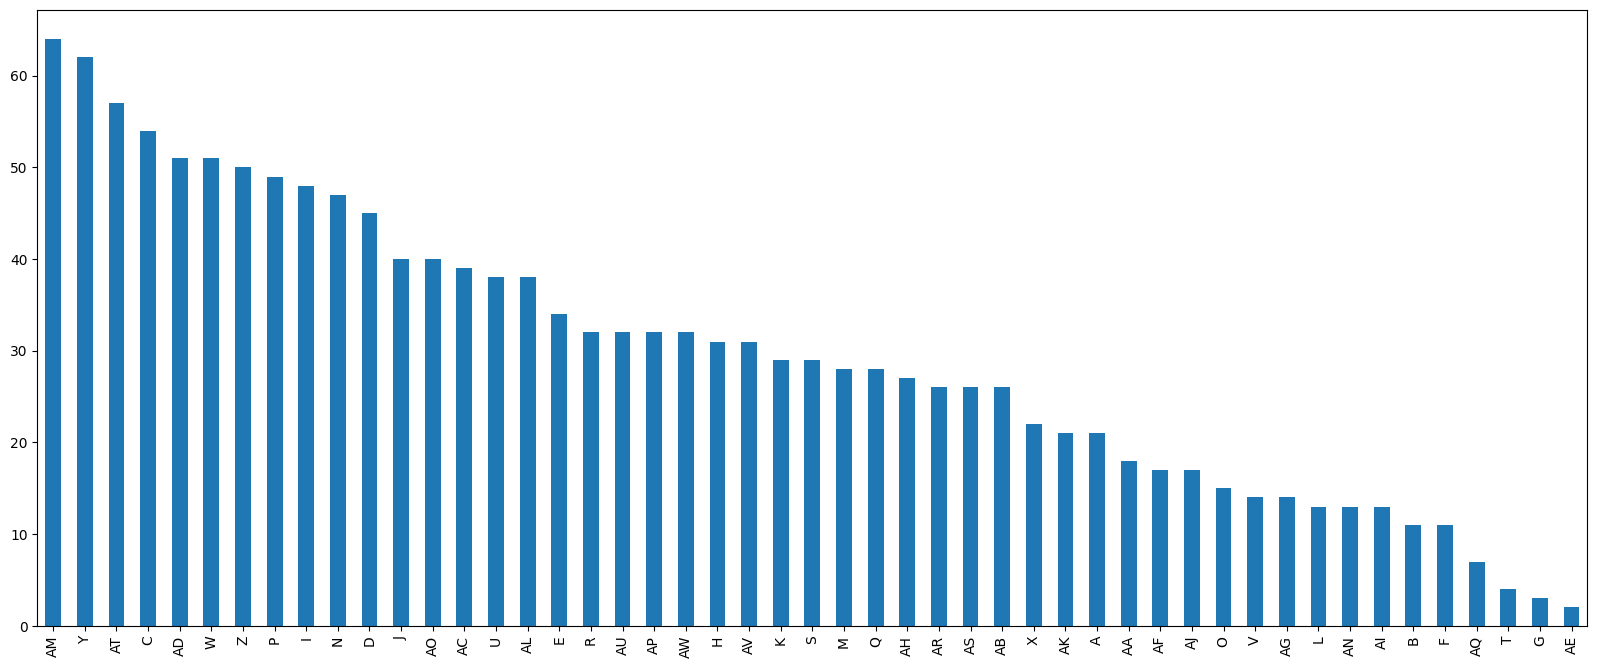

In [ ]:
# Looking at distribution of dropoff_neighborhood
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,8))

- Most of the pickup and dropoff are from area AT,AD,AM implies these are are the most busy in the city.
- Areas like T,G are some areas from where very less number of pickups and dropoff are happening.

#### **Bivariate analysis**

**Checking the relationship between `trip_distance` and `trip_duration`**

<Axes: xlabel='trip_distance', ylabel='trip_duration'>

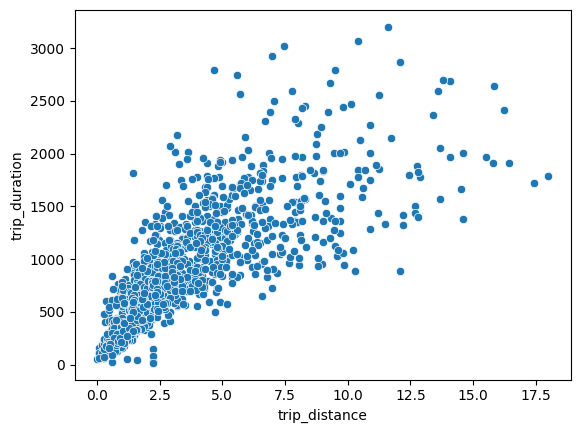

In [ ]:
# Generating a scatter plot of trip_duration vs trip_distance
sns.scatterplot(x = trips['trip_distance'], y = trips['trip_duration'])

- There is strong positive correlation between trip_distance and trip_duration.

**Checking the relationship between `payment_type` and `passenger_count`**

<Axes: xlabel='passenger_count', ylabel='count'>

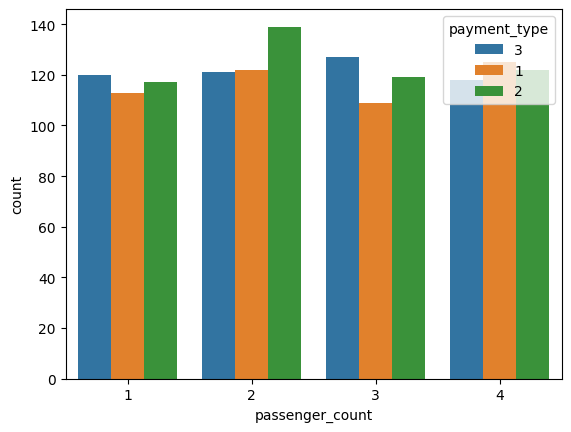

In [ ]:
# Looking at how passeger count affects payment_type
sns.countplot(x = trips['passenger_count'],hue=trips['payment_type'])

- There is no such specific pattern can be observed.

### **Data Preparation**


**Creating entities and relationships:**

* The three entities in this data are
  * `trips`
  * `pickup_neighborhoods`
  * `dropoff_neighborhoods`

* This data has the following relationships
  * `pickup_neighborhoods` --> trips (one neighborhood can have multiple trips that start in it. This means pickup_neighborhoods is the ``parent_entity`` and trips is the child entity)
  * `dropoff_neighborhoods` --> trips (one neighborhood can have multiple trips that end in it. This means dropoff_neighborhoods is the ``parent_entity`` and trips is the child entity)

In [featuretools](https://featuretools.alteryx.com/en/v0.27.0/getting_started/getting_started_index.html) (automated feature engineering software package), we specify the list of entities and relationships as follows:

In [ ]:
# Define entities and relationships for the Deep Feature Synthesis
entities = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

In [ ]:
# Specifying the cutoff time
cutoff_time = trips[['id', 'pickup_datetime']]
preview(cutoff_time, 10)

,id,pickup_datetime
0,0,2019-01-01 00:00:00
1004,1004,2019-01-01 02:39:00
1003,1003,2019-01-01 02:39:00
1002,1002,2019-01-01 02:39:00
1001,1001,2019-01-01 02:39:00
1000,1000,2019-01-01 02:39:00
999,999,2019-01-01 02:39:00
998,998,2019-01-01 02:39:00
997,997,2019-01-01 02:38:00
1005,1005,2019-01-01 02:39:00


**Steps for Feature Engineering**

1. **Creating baseline features using Deep Feature Synthesis**

  Instead of manually creating features, such as "month of pickup datetime", we can let DFS come up with them automatically. It does this by
  * interpreting the variable types of the columns e.g categorical, numeric and others
  * matching the columns to the primitives that can be applied to their variable types
  * creating features based on these matches

2. **Create transform features using transform primitives**

  As we described in the video, features fall into two major categories, ``transform`` and ``aggregate``. In featureools, we can create transform features by specifying ``transform`` primitives. Below we specify a ``transform`` primitive called ``weekend`` and here is what it does:

  * It can be applied to any ``datetime`` column in the data.
  * For each entry in the column, it assess if it is a ``weekend`` and returns a boolean.

  In this specific data, there are one ``datetime`` column ``pickup_datetime``. The tool automatically creates features using the primitive and these two columns as shown below.

### **Creating a baseline model with only 1 transform primitive**
  

#### **Feature Engineering using DFS**

**Defining transform primitive for weekend and defining features using DFS**

In [ ]:
# Initiang transform primitive for weekend
trans_primitives = [IsWeekend]

# Utilizing DFS
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [ ]:
# Checking the features created using DFS
print ("Number of features: %d" % len(features))
features

Number of features: 12


[<Feature: Transport_service>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

**Computing features and defining feature matrix**

In [ ]:
# Defining a function that generates features from data according to set cutoff_time
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix

In [ ]:
# Initiating the compute_features function
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [ ]:
# Looking at the generated feature matrix
preview(feature_matrix1, 5)

,payment_type,pickup_neighborhoods.longitude,dropoff_neighborhood = AM,dropoff_neighborhood = Y,dropoff_neighborhood = AT,dropoff_neighborhood = C,dropoff_neighborhood = W,dropoff_neighborhood = AD,dropoff_neighborhood = Z,dropoff_neighborhood = P,...,pickup_neighborhood = I,pickup_neighborhood = R,dropoff_neighborhoods.latitude,Transport_service,trip_duration,trip_distance,dropoff_neighborhoods.longitude,pickup_neighborhoods.latitude,passenger_count,IS_WEEKEND(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
0,3,-73.961716,False,False,False,True,False,False,False,False,...,False,False,40.783780,3,387,1.32,-73.953145,40.804349,1,False
1004,1,-73.919159,False,False,False,False,True,False,False,False,...,False,False,40.766575,4,1215,4.00,-73.919853,40.744928,1,False
1003,1,-73.954298,False,False,False,False,False,False,True,False,...,False,False,40.715828,3,215,0.63,-73.954298,40.715828,4,False
1002,2,-73.981693,True,False,False,False,False,False,False,False,...,False,False,40.775357,2,561,3.20,-73.949840,40.729670,3,False
1001,2,-73.998366,False,False,False,False,False,False,False,False,...,False,False,40.793597,1,1576,8.28,-73.969822,40.721435,3,False


In [ ]:
# Checking the shape of the matrix
feature_matrix1.shape

(1452, 30)

* Here it is seen that 30 features are generated
* It is also noticed that the number of data points, after applying the cutoff_time filter is 1452 entries

#### **Model Building**


> **Transforming the duration variable using sqrt and log**

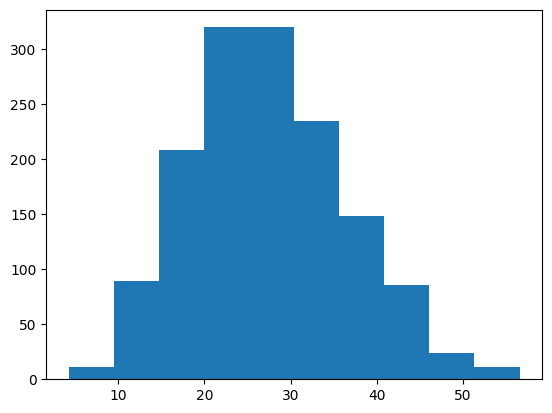

In [ ]:
# Checking distribution of sqrt-transformed trips
plt.hist(np.sqrt(trips['trip_duration']))
plt.show()

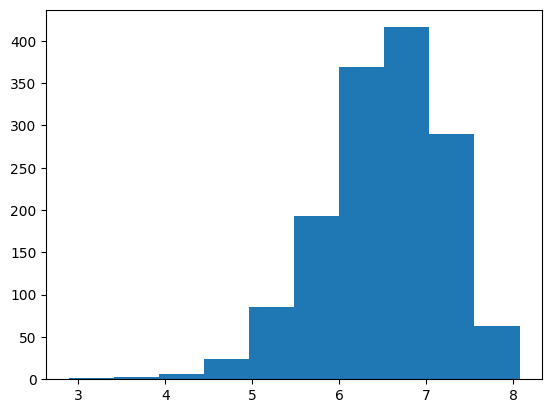

In [ ]:
# Checking distribution of log-transformed trips
plt.hist(np.log(trips['trip_duration']))
plt.show()

- We can clearly see that the sqrt transformation is giving nearly normal distribution, there for we can choose the sqrt transformation on the dependent(trip_duration) variable.

> **Splitting the data into train and test**

In [ ]:
# Separates the whole feature matrix into train data feature matrix,train data labels, and test data feature matrix
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

> **Defining function for to check the performance of the model.**

In [ ]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

> **Building Linear regression using only weekend transform primitive**

In [ ]:
# Defining the model
lr1=LinearRegression()

# Fitting the model
lr1.fit(X_train,y_train)

LinearRegression()

In [ ]:
# Check the performance of the model
model_pref(lr1, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.662819  5.246785  4.052007
1   Test  0.583352  5.583601  4.172844


- Model is giving only 0.58 Rsquared, with RSME of 5.58 and MAE of ~4.17.
- Model is slightly overfitting.

> **Building a decision tree using only weekend transform primitive**

In [ ]:
# Defining the model
dt = DecisionTreeRegressor()

# Fitting the model
dt.fit(X_train,y_train)

DecisionTreeRegressor()

In [ ]:
# Check the performance of the model
model_pref(dt, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.000000  0.000000
1   Test  0.510486  6.052185  4.618472


- The model is overfitting a lot, with train R2 as 1 while test R2 as 0.46
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

> **Building Pruned decision tree using only weekend transform primitive**

In [ ]:
# Defining the model
dt_pruned = DecisionTreeRegressor(max_depth = 3)

# Fitting the model
dt_pruned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [ ]:
# Check the performance of the model
model_pref(dt_pruned, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.748675  4.529805  3.404459
1   Test  0.681276  4.883566  3.780489


- The pruned model is performing better that both baseline decision tree and linear regression, with R2 as ~.68.

> **Building Random Forest using only weekend transform primitive**

In [ ]:
# Defining the model
rf = RandomForestRegressor(n_estimators = 60, max_depth = 4)

In [ ]:
# Fitting the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=60)

In [ ]:
# Check the performance of the model
model_pref(rf, X_train, X_test, y_train, y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.811964  3.918168  2.896523
1   Test  0.736992  4.436234  3.508571


- The score for the model with only 1 transform primitive is ~73%.
- This model is performing little better than pruned decision tree model.
- Model is slightly overfitting.

### **Creating models with more transform primitives**

**Adding more Transform Primitives and creating new model**

* Add ``Minute``, ``Hour``, ``Month``, ``Weekday`` , etc primitives
* All these transform primitives apply to ``datetime`` columns

#### **Feature Engineering using DFS**

**Defining transform primitive for weekend and defining features using DFS**

In [ ]:
# Initiang transform primitive
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

# Utilizing DFS
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [ ]:
# Checking the features created using DFS
print ("Number of features: %d" % len(features))
features

Number of features: 17


[<Feature: Transport_service>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

**Computing features and defining feature matrix**

In [ ]:
# Initiating the compute_features function
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [ ]:
# Looking at the generated feature matrix
feature_matrix2.head()

,dropoff_neighborhoods.longitude,HOUR(pickup_datetime),dropoff_neighborhoods.latitude,MONTH(pickup_datetime),trip_duration,pickup_neighborhoods.latitude,DAY(pickup_datetime),Transport_service,trip_distance,IS_WEEKEND(pickup_datetime),...,pickup_neighborhood = AC,pickup_neighborhood = P,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = I,pickup_neighborhood = R,payment_type,passenger_count,MINUTE(pickup_datetime),WEEKDAY(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
0,-73.953145,0,40.783780,1,387,40.804349,1,3,1.32,False,...,False,False,False,False,False,False,3,1,0,1
1,-73.934381,0,40.836792,1,1568,40.715828,1,1,13.70,False,...,False,False,False,False,False,False,3,3,1,1
2,-73.948046,0,40.818445,1,1219,40.750179,1,4,5.30,False,...,False,False,False,False,False,False,1,1,1,1
3,-73.940427,0,40.799573,1,873,40.729670,1,2,7.19,False,...,False,False,False,False,False,False,2,2,1,1
4,-73.982322,0,40.776270,1,1091,40.749843,1,1,2.90,False,...,False,False,False,False,False,False,1,2,2,1


In [ ]:
# Checking the shape of the matrix
feature_matrix2.shape

(1452, 35)

* Here it is seen that 35 features are generated
* It is also noticed that the number of data points, after applying the cutoff_time filter is 1452 entries

**Splitting the Data**

In [ ]:
# Separates the whole feature matrix into train data feature matrix,train data labels, and test data feature matrix
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

#### **Model Building**


> **Building Linear regression using only weekend transform primitive**

In [ ]:
# Defining the model
lr2=LinearRegression()

# Fitting the data
lr2.fit(X_train2,y_train2)

LinearRegression()

In [ ]:
# Check the performance of the model
model_pref(lr2, X_train2, X_test2,y_train2,y_test2)

    Data  RSquared      RMSE       MAE
0  Train  0.663515  5.241371  4.060878
1   Test  0.602172  5.456041  4.065442


- Model is giving 0.60 Rsquared, with RSME of 5.45 and MAE of ~4.06.
- Model performance has not improved much from the last model by adding more transform primitives
- Model is not overfitting, and giving generalized results.

> **Building Decision tree using more transform primitive**

In [ ]:
# Defining the model
dt2=DecisionTreeRegressor()

# Fitting the data
dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

In [ ]:
# Check the performance of the model
model_pref(dt2, X_train2, X_test2,y_train2,y_test2)

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.000000  0.000000
1   Test  0.494018  6.153146  4.552329


- The model is overfitting a lot, with train R2 as 1 while test R2 as 0.46.
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

> **Building Pruned Decision tree using more transform primitive**

In [ ]:
# Defining the model
dt_pruned2=DecisionTreeRegressor(max_depth=4)

# Fitting the data
dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=4)

In [ ]:
# Check the performance of the model
model_pref(dt_pruned2, X_train2, X_test2,y_train2,y_test2)

    Data  RSquared      RMSE       MAE
0  Train  0.782259  4.216308  3.142310
1   Test  0.707492  4.678412  3.642763


- Model is giving ~0.70 Rsquared, with RSME of 4.67 and MAE of ~3.64.
- Model performance has improved by adding more transform features.
- Model is slightly overfitting.

> **Building Random Forest using more transform primitive**

In [ ]:
# Defining the model
rf2=RandomForestRegressor(n_estimators=60,max_depth=4)

# Fitting the data
rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=4, n_estimators=60)

In [ ]:
# Check the performance of the model
model_pref(rf2, X_train2, X_test2,y_train2,y_test2)

    Data  RSquared      RMSE       MAE
0  Train  0.813562  3.901481  2.889116
1   Test  0.738852  4.420513  3.502202


- The score for the model with more transform primitive is ~74%.
- As compared to previous model, the score has improved significantly.

### **Creating Models with Transform and Aggregate primitives**


**Adding Aggregation Primitives**

* These primitives will generate features for the parent entities ``pickup_neighborhoods``, and ``dropoff_neighborhood`` and then add them to the trips entity, which is the entity for which we are trying to make prediction.

#### **Feature Engineering using DFS**

**Defining transform and aggregation primitive and defining features using DFS**

In [ ]:
# Initiang transform and aggregation primitives
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

# Utilizing DFS
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [ ]:
# Checking the features created using DFS
print ("Number of features: %d" % len(features))
features

Number of features: 67


[<Feature: Transport_service>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.Transport_service)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_duration)>,
 <Feature: pickup_neighborhoods.MEAN(trips.Transport_service)>,
 <Feature: pickup_neighborhoods.MEAN(trips.

**Computing features and defining feature matrix**

In [ ]:
# Initiating the compute_features function
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [ ]:
# Looking at the generated feature matrix
feature_matrix3.head()

,dropoff_neighborhoods.STD(trips.Transport_service),pickup_neighborhoods.MEDIAN(trips.Transport_service),dropoff_neighborhood = AM,dropoff_neighborhood = Y,dropoff_neighborhood = AT,dropoff_neighborhood = C,dropoff_neighborhood = W,dropoff_neighborhood = AD,dropoff_neighborhood = Z,dropoff_neighborhood = P,...,pickup_neighborhood = AO,pickup_neighborhood = N,pickup_neighborhood = I,pickup_neighborhood = R,pickup_neighborhoods.COUNT(trips),pickup_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhoods.SUM(trips.passenger_count),pickup_neighborhoods.MAX(trips.trip_distance),dropoff_neighborhoods.STD(trips.passenger_count),payment_type
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,False,False,False,True,False,False,False,False,...,False,False,False,False,0.0,NaN,0.0,NaN,NaN,3
1,NaN,NaN,False,False,False,False,False,False,False,False,...,False,False,False,False,0.0,NaN,0.0,NaN,NaN,3
2,NaN,NaN,False,False,False,False,False,False,False,False,...,False,False,False,False,0.0,NaN,0.0,NaN,NaN,1
3,NaN,NaN,False,False,False,False,False,False,False,False,...,False,False,False,False,0.0,NaN,0.0,NaN,NaN,2
4,NaN,NaN,False,False,False,False,False,False,False,False,...,False,False,False,False,0.0,NaN,0.0,NaN,NaN,1


#### **Model Building**


**Data Splitting**

In [ ]:
# Separates the whole feature matrix into train data feature matrix,train data labels, and test data feature matrix
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

> **Building  Linear regression model with transform and aggregate primitive.**

In [ ]:
# Defining the model
lr3=LinearRegression()

# Fitting the data
lr3.fit(X_train3,y_train3)

LinearRegression()

In [ ]:
# Check the performance of the model
model_pref(lr3, X_train3, X_test3,y_train3,y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.663515  5.241371  4.060878
1   Test  0.602172  5.456041  4.065442


- Model is giving only 0.60 Rsquared, with RSME of 5.45 and MAE of ~4.
- Model is not overfitting, and giving generalized results.


> **Building  Decision tree with transform and aggregate primitive.**

In [ ]:
# Defining the model
dt3=DecisionTreeRegressor()

# Fitting the data
dt3.fit(X_train3,y_train3)

DecisionTreeRegressor()

In [ ]:
# Check the performance of the model
model_pref(dt3, X_train3, X_test3,y_train3,y_test3)

    Data  RSquared     RMSE       MAE
0  Train    1.0000  0.00000  0.000000
1   Test    0.4392  6.47789  4.732509


- The model is overfitting a lot, with train R2 as 1 while test R2 as 0.44
- This generally happens in decision tree, one solution for this is to Prune the decision tree, let's try pruning and see if the performance improves.

> **Building Pruned Decision tree with transform and aggregate primitive.**

In [ ]:
# Defining the model
dt_pruned3=DecisionTreeRegressor(max_depth=4)

# Fitting the data
dt_pruned3.fit(X_train3,y_train3)

DecisionTreeRegressor(max_depth=4)

In [ ]:
# Check the performance of the model
model_pref(dt_pruned3, X_train3, X_test3,y_train3,y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.782259  4.216308  3.142310
1   Test  0.707492  4.678412  3.642763


- Model is giving ~0.70 Rsquared, with RSME of 4.6 and MAE of ~3.6.
- The model performance has not improved by adding aggregate primitives.
- Model is overfitting, and is not giving generalized results.

> **Building  Random Forest with transform and aggregate primitive.**

In [ ]:
# Defining the model
rf3=RandomForestRegressor(n_estimators=60,max_depth=4)

# Fitting the data
rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=4, n_estimators=60)

In [ ]:
# Check the performance of the model
model_pref(rf3, X_train3, X_test3,y_train3,y_test3)

    Data  RSquared      RMSE       MAE
0  Train  0.813266  3.904571  2.906086
1   Test  0.746608  4.354381  3.457472


- The model Performance has improved from ~0.73 by the addition of transform and aggregation features.

- The modeling score has not improved much after adding aggregate transforms, and also the training time was also increased by a significant amount, implies that adding more features is always not very effective.

### **Model Selection**

**Based on the above 3 models, we can make predictions using our model2, as it is giving almost same accuracy as model3 and also the training time is not that large as compared to model3**

In [ ]:
# Using the second Random Forest model to predict the target variable
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # Undo the sqrt we took earlier
y_pred[5:]

array([1335.20203101,  482.67812667, 1172.85692861,  238.82524987,
       1382.84891484,  545.0083657 ,  674.60307763,  499.38394793,
       1562.61025505,  456.65608071, 1411.26372528,  249.99608835,
       1349.88267282,  428.62196148, 1807.65539475,  229.59015947,
       1078.15516894,  953.51343204, 1338.50488367, 1856.79492433,
        619.62728507,  608.24336352, 1340.86367619,  835.70201067,
        494.4730085 ,  732.45153482,  383.8538443 ,  485.34810139,
        490.13576364, 1347.90825309,  267.51782144, 1399.76520848,
        489.9470725 ,  658.96837199, 1016.94610604,  917.25324373,
       1395.46266731,  658.96837199, 1826.30837487,  625.32467255,
        299.39887048,  321.3486856 ,  689.9825231 ,  373.8254807 ,
        498.56227082,  669.62595248,  321.3486856 ,  653.62910147,
        518.26795727,  484.53805852, 1766.1725767 ,  491.04019217,
        899.82140672, 1552.70263118,  181.20463061,  230.34496027,
       1465.05109022, 1099.44466303, 1170.91074293,  669.67259

- Trip_Distance is the most important feature, which implies that the longer the trip is the longer duration of the trip is.
- Features like dropoff_neighborhoods.longitude, pickup_neighborhoods.longitude, dropoff_neighborhoods.latitude,pickup_neighborhoods.latitude signifies that trip duration is impacted by pickup and dropoff locations.

**Looking at the important features based on `model2` and how can they affect the duration of the rides**

In [ ]:
# Looking at the important features based on the chosen predictive model
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.941
2: Feature: dropoff_neighborhoods.longitude, 0.018
3: Feature: dropoff_neighborhoods.latitude, 0.015
4: Feature: pickup_neighborhoods.longitude, 0.015
5: Feature: pickup_neighborhoods.latitude, 0.005
6: Feature: dropoff_neighborhood = P, 0.001
7: Feature: payment_type, 0.001
8: Feature: MINUTE(pickup_datetime), 0.001
9: Feature: pickup_neighborhood = AD, 0.001
10: Feature: dropoff_neighborhood = AT, 0.001


### **Conclusions and Summary**

- In this work, a various predictive models were trained on the New York Bus Ride datasets given
- For the objectives, the following model building strategies were adopted:
  1. Baseline Model
  2. Model with Transform Primitives
  3. Model with Transform and Aggregate Primitives
- For each strategy, feature engineering was carried out using the DFS method to generate feature columns from the given data. Afterwards, the folllowing different Machine Learning Regression Models were implemented:
  1. Linear Model
  2. Decision Tree
  3. Pruned Decision Tree
  4. Random Forest
- Each model was fitted against the training data and their respective performances were determined.
- Comparing said performance, the second random forest model (Random Forest Baseline model with transform primitives) scored the highest and was used to create the final predictive model to predict on the test dataset
